## Kaggel: Digit Recognizer(MNIST)  by GPyOpt  
Kaggle Digit recognizer: https://www.kaggle.com/c/digit-recognizer  
GPyOpt: https://github.com/SheffieldML/GPyOpt  

### Score:
* initial_design_numdata=20, max_iter=50,  score: 99.457 (515 mins: NVIDIA GTX1060)

In [32]:
import warnings
warnings.filterwarnings('ignore')

import GPy
import GPyOpt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# fix random seed
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 123
rn.seed(seed)
np.random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Data preparation: MNIST from Kaggle

In [33]:
train = pd.read_csv('../train.csv')
label = train.label
train = train.drop(['label'], axis=1)
train = train.values.reshape(-1, 28, 28, 1)

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

[x_train.shape, x_val.shape, x_test.shape]

[(35700, 28, 28, 1), (6300, 28, 28, 1), (6300, 28, 28, 1)]

## Hyperparameters:

In [34]:
params = [
    {'name': 'Dropout_0',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_1',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_2',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_3',        'type': 'continuous',  'domain': (0.0, 0.5)},
    {'name': 'Dropout_4',        'type': 'continuous',  'domain': (0.0, 0.5)}
    #{'name': 'Dense_0',          'type': 'discrete',    'domain': (128,256, 512)},
    #{'name': 'Dense_1',          'type': 'discrete',    'domain': (64,128, 256)},
    #{'name': 'validation_split', 'type': 'continuous',  'domain': (0.1, 0.3)}
]

## CNN Model:

In [35]:
cnt = 0
def cnn_model(x):
    
    def Param(p_name):
        p_index = [p['name'] for p in params].index(p_name)
        p_type = params[p_index]['type']
        
        if type(x) is np.ndarray:
            if p_type == 'continuous':
                return float(x[:, p_index])
            else:
                return int(x[:, p_index])
        else: # list
            if p_type == 'continuous':
                return float(params[p_index]['domain'])
            else:
                return int(params[p_index]['domain'])
    
    initializer = keras.initializers.glorot_uniform(seed=seed)
    batch_size = 32
    
    model = Sequential() 
        
    model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer=initializer, input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(Param('Dropout_0'), seed=seed))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(Param('Dropout_1'), seed=seed))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(Param('Dropout_2'), seed=seed))

    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_3'), seed=seed))
    model.add(Dense(128, activation = "relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(Param('Dropout_4'), seed=seed))
    
    model.add(Dense(10, activation = "softmax", kernel_initializer=initializer))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1)

    datagen.fit(x_train, seed=seed)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                        epochs=50, 
                                        validation_data=(x_val, y_val),
                                        steps_per_epoch=x_train.shape[0]//batch_size,
                                        callbacks=[reduce_lr, early_stop],
                                        verbose=2)
    
    loss = hist.history['val_loss'][-1]
    acc = hist.history['val_acc'][-1]
    
    global cnt
    print(cnt, ': Test_loss:', loss, ', Test_acc:', acc)
    print('Model: ', model, '\n\n')
    cnt += 1
    
    return loss, acc, model, hist

## Fitting function:  
return a negative accuracy value  

In [36]:
def f(x):
    loss, acc, model, hist = cnn_model(x)
    return -acc

## Bayesian Optimization:
:model_type: type of model to use as surrogate:
        - 'GP', standard Gaussian process.
        - 'GP_MCMC', Gaussian process with prior in the hyper-parameters.
        - 'sparseGP', sparse Gaussian process.
        - 'warperdGP', warped Gaussian process.
        - 'InputWarpedGP', input warped Gaussian process
        - 'RF', random forest (scikit-learn).  
:acquisition_type: type of acquisition function to use.
        - 'EI', expected improvement.
        - 'EI_MCMC', integrated expected improvement (requires GP_MCMC model).
        - 'MPI', maximum probability of improvement.
        - 'MPI_MCMC', maximum probability of improvement (requires GP_MCMC model).
        - 'LCB', GP-Lower confidence bound.
        - 'LCB_MCMC', integrated GP-Lower confidence bound (requires GP_MCMC model).

In [37]:
opt = GPyOpt.methods.BayesianOptimization(f=f, 
                                          domain=params,
                                          initial_design_numdata = 30,
                                          model_type='GP_MCMC',
                                          acquisition_type='EI_MCMC',
                                          exact_feval=False)
# initial_design_num:30   2,5hrs

Epoch 1/50
 - 29s - loss: 0.3758 - acc: 0.8839 - val_loss: 0.0477 - val_acc: 0.9854
Epoch 2/50
 - 26s - loss: 0.1209 - acc: 0.9641 - val_loss: 0.0510 - val_acc: 0.9851
Epoch 3/50
 - 26s - loss: 0.0973 - acc: 0.9717 - val_loss: 0.0422 - val_acc: 0.9867
Epoch 4/50
 - 26s - loss: 0.0819 - acc: 0.9760 - val_loss: 0.0305 - val_acc: 0.9917
Epoch 5/50
 - 26s - loss: 0.0789 - acc: 0.9775 - val_loss: 0.0392 - val_acc: 0.9881
Epoch 6/50
 - 26s - loss: 0.0680 - acc: 0.9814 - val_loss: 0.0434 - val_acc: 0.9876

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 26s - loss: 0.0488 - acc: 0.9867 - val_loss: 0.0195 - val_acc: 0.9937
Epoch 8/50
 - 26s - loss: 0.0411 - acc: 0.9881 - val_loss: 0.0218 - val_acc: 0.9938
Epoch 9/50
 - 26s - loss: 0.0411 - acc: 0.9880 - val_loss: 0.0161 - val_acc: 0.9941
Epoch 10/50
 - 25s - loss: 0.0402 - acc: 0.9888 - val_loss: 0.0192 - val_acc: 0.9946
Epoch 11/50
 - 26s - loss: 0.0407 - acc: 0.9886 - val_loss: 0.0167 - val_acc: 

Epoch 4/50
 - 26s - loss: 0.0753 - acc: 0.9779 - val_loss: 0.0294 - val_acc: 0.9905
Epoch 5/50
 - 26s - loss: 0.0723 - acc: 0.9782 - val_loss: 0.0262 - val_acc: 0.9917
Epoch 6/50
 - 26s - loss: 0.0649 - acc: 0.9823 - val_loss: 0.0307 - val_acc: 0.9897
Epoch 7/50
 - 26s - loss: 0.0594 - acc: 0.9821 - val_loss: 0.0302 - val_acc: 0.9898

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/50
 - 26s - loss: 0.0395 - acc: 0.9891 - val_loss: 0.0231 - val_acc: 0.9917
Epoch 9/50
 - 26s - loss: 0.0377 - acc: 0.9890 - val_loss: 0.0169 - val_acc: 0.9952
Epoch 10/50
 - 26s - loss: 0.0364 - acc: 0.9895 - val_loss: 0.0173 - val_acc: 0.9956
Epoch 11/50
 - 26s - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0179 - val_acc: 0.9951

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
 - 26s - loss: 0.0253 - acc: 0.9923 - val_loss: 0.0142 - val_acc: 0.9962
Epoch 13/50
 - 26s - loss: 0.0229 - acc: 0.9933 - val_loss: 0.0149 - val_acc: 0

Epoch 11/50
 - 26s - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0146 - val_acc: 0.9965
Epoch 12/50
 - 26s - loss: 0.0315 - acc: 0.9907 - val_loss: 0.0168 - val_acc: 0.9940
Epoch 13/50
 - 26s - loss: 0.0285 - acc: 0.9912 - val_loss: 0.0141 - val_acc: 0.9959
Epoch 14/50
 - 26s - loss: 0.0280 - acc: 0.9919 - val_loss: 0.0217 - val_acc: 0.9933
Epoch 15/50
 - 27s - loss: 0.0265 - acc: 0.9924 - val_loss: 0.0159 - val_acc: 0.9954

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/50
 - 27s - loss: 0.0181 - acc: 0.9945 - val_loss: 0.0116 - val_acc: 0.9965
Epoch 17/50
 - 27s - loss: 0.0175 - acc: 0.9948 - val_loss: 0.0136 - val_acc: 0.9957
Epoch 18/50
 - 26s - loss: 0.0165 - acc: 0.9951 - val_loss: 0.0129 - val_acc: 0.9962

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 19/50
 - 27s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.0111 - val_acc: 0.9965
Epoch 20/50
 - 26s - loss: 0.0136 - acc: 0.9959 - val_loss: 0.0124 - val_

Epoch 17/50
 - 27s - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0144 - val_acc: 0.9960
Epoch 18/50
 - 27s - loss: 0.0174 - acc: 0.9946 - val_loss: 0.0132 - val_acc: 0.9962

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 19/50
 - 27s - loss: 0.0145 - acc: 0.9954 - val_loss: 0.0102 - val_acc: 0.9968
Epoch 20/50
 - 27s - loss: 0.0109 - acc: 0.9968 - val_loss: 0.0118 - val_acc: 0.9965
Epoch 21/50
 - 27s - loss: 0.0132 - acc: 0.9959 - val_loss: 0.0130 - val_acc: 0.9963

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/50
 - 27s - loss: 0.0107 - acc: 0.9965 - val_loss: 0.0116 - val_acc: 0.9962
Epoch 23/50
 - 27s - loss: 0.0096 - acc: 0.9972 - val_loss: 0.0118 - val_acc: 0.9963

Epoch 00023: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 24/50
 - 28s - loss: 0.0082 - acc: 0.9976 - val_loss: 0.0117 - val_acc: 0.9962
Epoch 00024: early stopping
9 : Test_loss: 0.011741767451333414 , Test_acc: 0.

Epoch 31/50
 - 28s - loss: 0.0085 - acc: 0.9976 - val_loss: 0.0100 - val_acc: 0.9968

Epoch 00031: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 32/50
 - 28s - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0101 - val_acc: 0.9970
Epoch 00032: early stopping
12 : Test_loss: 0.010082707245324162 , Test_acc: 0.996984126984127
Model:  <keras.engine.sequential.Sequential object at 0x7fe8bae1e940> 


Epoch 1/50
 - 35s - loss: 0.3082 - acc: 0.9064 - val_loss: 0.0538 - val_acc: 0.9844
Epoch 2/50
 - 28s - loss: 0.1101 - acc: 0.9669 - val_loss: 0.0318 - val_acc: 0.9913
Epoch 3/50
 - 28s - loss: 0.0883 - acc: 0.9741 - val_loss: 0.0381 - val_acc: 0.9897
Epoch 4/50
 - 28s - loss: 0.0735 - acc: 0.9782 - val_loss: 0.0413 - val_acc: 0.9886

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
 - 28s - loss: 0.0507 - acc: 0.9852 - val_loss: 0.0257 - val_acc: 0.9924
Epoch 6/50
 - 28s - loss: 0.0491 - acc: 0.9864 - val_loss: 0.0385 - val_acc: 0.9

Epoch 20/50
 - 28s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0119 - val_acc: 0.9967

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 21/50
 - 28s - loss: 0.0106 - acc: 0.9968 - val_loss: 0.0118 - val_acc: 0.9963
Epoch 00021: early stopping
15 : Test_loss: 0.011820492624445626 , Test_acc: 0.9963492063492063
Model:  <keras.engine.sequential.Sequential object at 0x7fe897368048> 


Epoch 1/50
 - 36s - loss: 0.2983 - acc: 0.9065 - val_loss: 0.0839 - val_acc: 0.9748
Epoch 2/50
 - 29s - loss: 0.1078 - acc: 0.9668 - val_loss: 0.0387 - val_acc: 0.9873
Epoch 3/50
 - 29s - loss: 0.0853 - acc: 0.9750 - val_loss: 0.0400 - val_acc: 0.9881
Epoch 4/50
 - 29s - loss: 0.0719 - acc: 0.9783 - val_loss: 0.0414 - val_acc: 0.9881

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
 - 29s - loss: 0.0530 - acc: 0.9842 - val_loss: 0.0243 - val_acc: 0.9930
Epoch 6/50
 - 29s - loss: 0.0491 - acc: 0.9857 - val_loss: 0.0289 - val_acc: 0

Epoch 7/50
 - 29s - loss: 0.0465 - acc: 0.9860 - val_loss: 0.0279 - val_acc: 0.9917

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/50
 - 29s - loss: 0.0325 - acc: 0.9904 - val_loss: 0.0208 - val_acc: 0.9937
Epoch 9/50
 - 29s - loss: 0.0298 - acc: 0.9910 - val_loss: 0.0131 - val_acc: 0.9959
Epoch 10/50
 - 29s - loss: 0.0290 - acc: 0.9920 - val_loss: 0.0132 - val_acc: 0.9965
Epoch 11/50
 - 29s - loss: 0.0280 - acc: 0.9915 - val_loss: 0.0126 - val_acc: 0.9963
Epoch 12/50
 - 29s - loss: 0.0246 - acc: 0.9921 - val_loss: 0.0134 - val_acc: 0.9962
Epoch 13/50
 - 29s - loss: 0.0272 - acc: 0.9920 - val_loss: 0.0127 - val_acc: 0.9965

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14/50
 - 29s - loss: 0.0208 - acc: 0.9946 - val_loss: 0.0110 - val_acc: 0.9968
Epoch 15/50
 - 29s - loss: 0.0180 - acc: 0.9950 - val_loss: 0.0101 - val_acc: 0.9971
Epoch 16/50
 - 29s - loss: 0.0169 - acc: 0.9952 - val_loss: 0.0108 - val_acc

Epoch 5/50
 - 30s - loss: 0.0779 - acc: 0.9764 - val_loss: 0.0299 - val_acc: 0.9908
Epoch 6/50
 - 30s - loss: 0.0626 - acc: 0.9811 - val_loss: 0.0210 - val_acc: 0.9930
Epoch 7/50
 - 30s - loss: 0.0584 - acc: 0.9820 - val_loss: 0.0252 - val_acc: 0.9916
Epoch 8/50
 - 30s - loss: 0.0535 - acc: 0.9846 - val_loss: 0.0250 - val_acc: 0.9917

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/50
 - 30s - loss: 0.0380 - acc: 0.9889 - val_loss: 0.0124 - val_acc: 0.9962
Epoch 10/50
 - 30s - loss: 0.0368 - acc: 0.9893 - val_loss: 0.0178 - val_acc: 0.9951
Epoch 11/50
 - 30s - loss: 0.0352 - acc: 0.9892 - val_loss: 0.0165 - val_acc: 0.9954

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
 - 30s - loss: 0.0262 - acc: 0.9915 - val_loss: 0.0104 - val_acc: 0.9971
Epoch 13/50
 - 30s - loss: 0.0246 - acc: 0.9926 - val_loss: 0.0121 - val_acc: 0.9956
Epoch 14/50
 - 30s - loss: 0.0245 - acc: 0.9929 - val_loss: 0.0134 - val_acc: 


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16/50
 - 30s - loss: 0.0168 - acc: 0.9946 - val_loss: 0.0117 - val_acc: 0.9965
Epoch 17/50
 - 30s - loss: 0.0162 - acc: 0.9956 - val_loss: 0.0116 - val_acc: 0.9965

Epoch 00017: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 18/50
 - 30s - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0108 - val_acc: 0.9971
Epoch 19/50
 - 30s - loss: 0.0134 - acc: 0.9961 - val_loss: 0.0101 - val_acc: 0.9973
Epoch 20/50
 - 30s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0116 - val_acc: 0.9970
Epoch 21/50
 - 30s - loss: 0.0122 - acc: 0.9967 - val_loss: 0.0113 - val_acc: 0.9971

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 22/50
 - 30s - loss: 0.0123 - acc: 0.9968 - val_loss: 0.0113 - val_acc: 0.9973
Epoch 23/50
 - 30s - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0108 - val_acc: 0.9975

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-


Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 21/50
 - 31s - loss: 0.0091 - acc: 0.9975 - val_loss: 0.0109 - val_acc: 0.9970
Epoch 00021: early stopping
27 : Test_loss: 0.010866867485400732 , Test_acc: 0.996984126984127
Model:  <keras.engine.sequential.Sequential object at 0x7fe87f199940> 


Epoch 1/50
 - 41s - loss: 0.2962 - acc: 0.9067 - val_loss: 0.0858 - val_acc: 0.9767
Epoch 2/50
 - 31s - loss: 0.1124 - acc: 0.9673 - val_loss: 0.0486 - val_acc: 0.9862
Epoch 3/50
 - 31s - loss: 0.0905 - acc: 0.9734 - val_loss: 0.0441 - val_acc: 0.9873
Epoch 4/50
 - 31s - loss: 0.0710 - acc: 0.9783 - val_loss: 0.0376 - val_acc: 0.9871
Epoch 5/50
 - 31s - loss: 0.0697 - acc: 0.9794 - val_loss: 0.0224 - val_acc: 0.9922
Epoch 6/50
 - 31s - loss: 0.0609 - acc: 0.9823 - val_loss: 0.0337 - val_acc: 0.9895
Epoch 7/50
 - 31s - loss: 0.0610 - acc: 0.9816 - val_loss: 0.0223 - val_acc: 0.9925
Epoch 8/50
 - 31s - loss: 0.0517 - acc: 0.9850 - val_loss: 0.0375 - val_acc: 0.

In [38]:
cnt = 0
opt.run_optimization(max_iter=30)
# max_iter: 50 ,7hrs

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Epoch 1/50
 - 42s - loss: 0.3862 - acc: 0.8792 - val_loss: 0.0593 - val_acc: 0.9808
Epoch 2/50
 - 31s - loss: 0.1290 - acc: 0.9607 - val_loss: 0.0593 - val_acc: 0.9840
Epoch 3/50
 - 31s - loss: 0.1047 - acc: 0.9686 - val_loss: 0.0419 - val_acc: 0.9867
Epoch 4/50
 - 31s - loss: 0.0870 - acc: 0.9751 - val_loss: 0.0253 - val_acc: 0.9914
Epoch 5/50
 - 31s - loss: 0.0855 - acc: 0.9748 - val_loss: 0.0402 - val_acc: 0.9879
Epoch 6/50
 - 32s - loss: 0.0718 - acc: 0.9790 - val_loss: 0.0278 - val_acc: 0.9906

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 31s - loss: 0.0520 - acc: 0.9851 - val_loss: 0.0198 - val_acc: 0.9935
Epoch 8/50
 - 31s - loss: 0.0464 - acc: 0.9861 - val_loss: 0.0224 - val_acc: 0.9927
Epoch 9/50
 - 31s - loss: 0.0453 - acc: 0.9868 - val_loss: 0.0225 - val_acc: 0.9941

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
 - 31s - loss: 0.0369 - acc: 0.9902 - val_loss: 0.0161 - val_acc: 0.99

Epoch 00022: early stopping
2 : Test_loss: 0.0104604045645101 , Test_acc: 0.9968253968253968
Model:  <keras.engine.sequential.Sequential object at 0x7fe874434cf8> 


Epoch 1/50
 - 43s - loss: 0.4241 - acc: 0.8672 - val_loss: 0.0712 - val_acc: 0.9790
Epoch 2/50
 - 32s - loss: 0.1451 - acc: 0.9571 - val_loss: 0.0497 - val_acc: 0.9841
Epoch 3/50
 - 32s - loss: 0.1104 - acc: 0.9674 - val_loss: 0.0393 - val_acc: 0.9865
Epoch 4/50
 - 32s - loss: 0.0893 - acc: 0.9741 - val_loss: 0.0326 - val_acc: 0.9897
Epoch 5/50
 - 32s - loss: 0.0881 - acc: 0.9740 - val_loss: 0.0416 - val_acc: 0.9879
Epoch 6/50
 - 32s - loss: 0.0746 - acc: 0.9786 - val_loss: 0.0343 - val_acc: 0.9895

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 32s - loss: 0.0587 - acc: 0.9834 - val_loss: 0.0197 - val_acc: 0.9940
Epoch 8/50
 - 32s - loss: 0.0494 - acc: 0.9862 - val_loss: 0.0260 - val_acc: 0.9913
Epoch 9/50
 - 32s - loss: 0.0485 - acc: 0.9857 - val_loss: 0.0170 - val_acc: 0.99


Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 33s - loss: 0.0493 - acc: 0.9857 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 8/50
 - 33s - loss: 0.0426 - acc: 0.9875 - val_loss: 0.0221 - val_acc: 0.9932
Epoch 9/50
 - 33s - loss: 0.0399 - acc: 0.9890 - val_loss: 0.0138 - val_acc: 0.9959
Epoch 10/50
 - 32s - loss: 0.0422 - acc: 0.9887 - val_loss: 0.0177 - val_acc: 0.9957
Epoch 11/50
 - 33s - loss: 0.0401 - acc: 0.9882 - val_loss: 0.0175 - val_acc: 0.9951

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12/50
 - 32s - loss: 0.0267 - acc: 0.9920 - val_loss: 0.0130 - val_acc: 0.9960
Epoch 13/50
 - 33s - loss: 0.0272 - acc: 0.9926 - val_loss: 0.0166 - val_acc: 0.9944
Epoch 14/50
 - 33s - loss: 0.0245 - acc: 0.9932 - val_loss: 0.0117 - val_acc: 0.9965
Epoch 15/50
 - 32s - loss: 0.0237 - acc: 0.9933 - val_loss: 0.0142 - val_acc: 0.9960
Epoch 16/50
 - 33s - loss: 0.0210 - acc: 0.9934 - val_loss: 0.0115 - val_acc

## Results:

In [39]:
x_best = opt.x_opt
print([i for i in x_best])

y_best = opt.fx_opt
print(y_best)

[0.3154880619272439, 0.25521116873900557, 0.1990928409589905, 0.49417270964141, 0.4196216739025418]
-0.9977777777777778


## Apply the best hyperparameters for the model:

In [40]:
best_params = params
p_type = [p['type'] for p in best_params]

for i in range(len(x_best)):
    best_params[i]['domain'] = x_best[i]
    if p_type[i] == 'discrete':
        best_params[i]['domain'] = int(best_params[i]['domain'])
        
best_params

[{'domain': 0.3154880619272439, 'name': 'Dropout_0', 'type': 'continuous'},
 {'domain': 0.25521116873900557, 'name': 'Dropout_1', 'type': 'continuous'},
 {'domain': 0.1990928409589905, 'name': 'Dropout_2', 'type': 'continuous'},
 {'domain': 0.49417270964141, 'name': 'Dropout_3', 'type': 'continuous'},
 {'domain': 0.4196216739025418, 'name': 'Dropout_4', 'type': 'continuous'}]

best params:  
[{'domain': 0.3622276624303176, 'name': 'Dropout_0', 'type': 'continuous'},  
 {'domain': 0.3015300642054637, 'name': 'Dropout_1', 'type': 'continuous'},  
 {'domain': 0.27719162485888604, 'name': 'Dropout_2', 'type': 'continuous'},  
 {'domain': 0.08554091460254953, 'name': 'Dropout_3', 'type': 'continuous'}]  

## Train with the best hyperparameters:

In [41]:
val_loss, val_acc, model, hist = cnn_model(best_params)

Epoch 1/50
 - 46s - loss: 0.3757 - acc: 0.8842 - val_loss: 0.0571 - val_acc: 0.9821
Epoch 2/50
 - 33s - loss: 0.1241 - acc: 0.9642 - val_loss: 0.0457 - val_acc: 0.9867
Epoch 3/50
 - 33s - loss: 0.0987 - acc: 0.9703 - val_loss: 0.0592 - val_acc: 0.9808
Epoch 4/50
 - 33s - loss: 0.0825 - acc: 0.9761 - val_loss: 0.0453 - val_acc: 0.9862
Epoch 5/50
 - 33s - loss: 0.0839 - acc: 0.9753 - val_loss: 0.0413 - val_acc: 0.9894
Epoch 6/50
 - 33s - loss: 0.0695 - acc: 0.9799 - val_loss: 0.0405 - val_acc: 0.9881
Epoch 7/50
 - 33s - loss: 0.0656 - acc: 0.9808 - val_loss: 0.0335 - val_acc: 0.9913
Epoch 8/50
 - 33s - loss: 0.0570 - acc: 0.9834 - val_loss: 0.0263 - val_acc: 0.9925
Epoch 9/50
 - 33s - loss: 0.0539 - acc: 0.9845 - val_loss: 0.0270 - val_acc: 0.9924
Epoch 10/50
 - 33s - loss: 0.0515 - acc: 0.9861 - val_loss: 0.0196 - val_acc: 0.9944
Epoch 11/50
 - 33s - loss: 0.0500 - acc: 0.9858 - val_loss: 0.0230 - val_acc: 0.9940
Epoch 12/50
 - 33s - loss: 0.0449 - acc: 0.9881 - val_loss: 0.0229 - val_a

In [42]:
model.evaluate(x_test, y_test, verbose=1)

6300/6300 [==============================] - 3s 437us/step


[0.012478048388147726, 0.9966666666666667]

## Prediction for the submission:

In [43]:
test = pd.read_csv('../test.csv')
test_index = test.index
test = test.values.reshape(-1,28,28,1).astype('float32') / 255.0

pred = model.predict(test, verbose=1)
result = pred.argmax(axis=1)

28000/28000 [==============================] - 17s 599us/step


## Submission cvs file output:

In [44]:
submission = pd.DataFrame({'ImageId': test_index+1, 'Label': result})
submission.to_csv('gpyopt_submission_gen.csv', index=False)

### approximate accuracy:

In [51]:
prev_result = pd.read_csv('../Hyperopt/hyperopt_gen_99685.csv', index_col=0)
curr_result = pd.read_csv('gpyopt_submission_gen.csv', index_col=0)
match_num = np.sum(prev_result.Label.values == curr_result.Label.values)
comp_acc = match_num / len(curr_result)
print('Approx. accuracy: {0:.5f}'.format(comp_acc))

Approx. accuracy: 0.99739


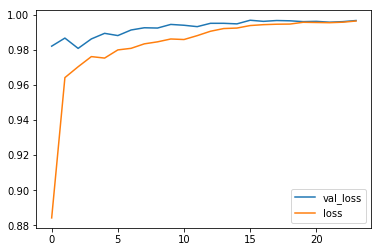

In [46]:
plt.plot(hist.history['val_acc'], label='val_loss')
plt.plot(hist.history['acc'], label='loss')
plt.legend()

In [192]:
acc_str = str(np.round(comp_acc, 5))[2:]
save_file = 'gpyopt_mnist_' + acc_str + '.hdf5'
print(save_file)
#model.save(save_file)

gpyopt_mnist_99739.hdf5


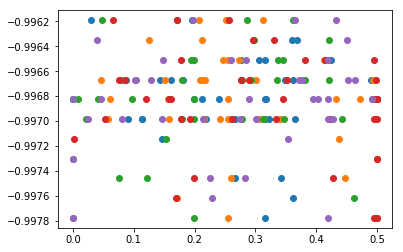

In [48]:
plt.plot(opt.X, opt.Y, 'o')

Difference: 73
Image Title: [previous result, current result, id number]


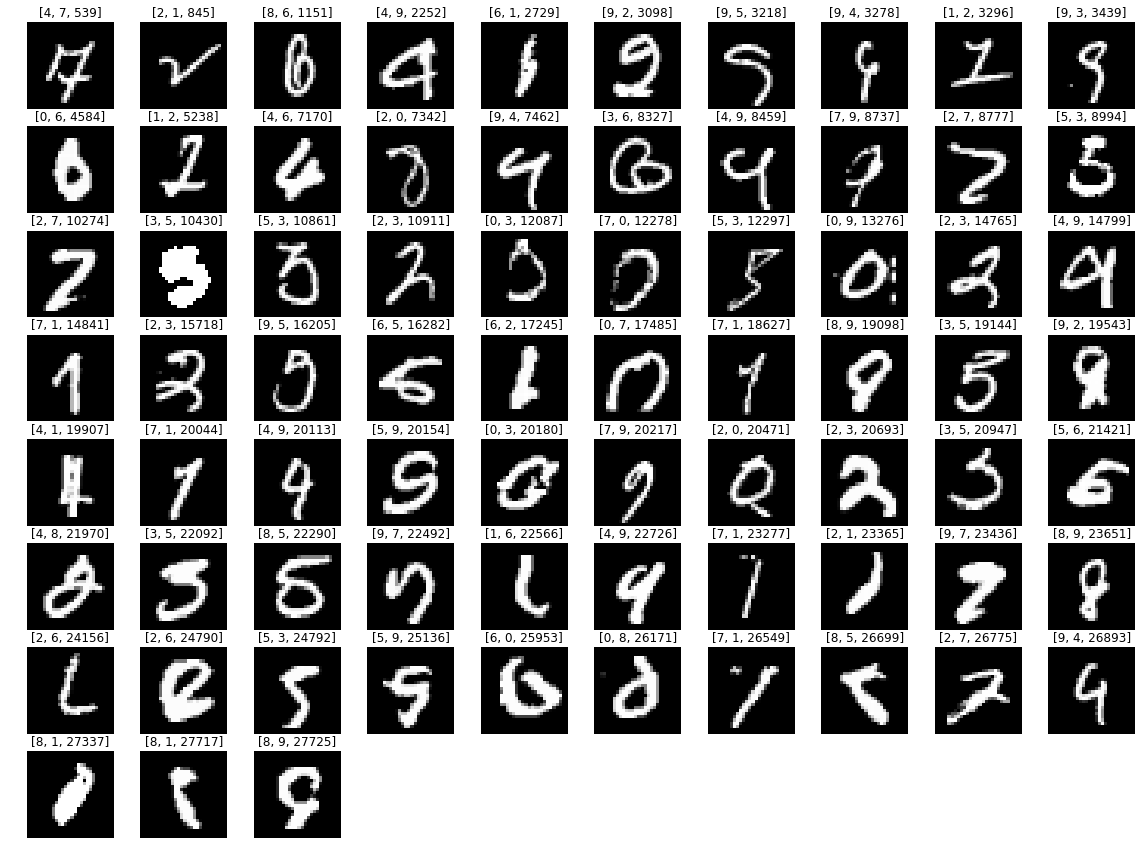

In [52]:
idx = prev_result[prev_result.Label.values != curr_result.Label.values].index
num=len(idx)
print('Difference:',num)
print('Image Title: [previous result, current result, id number]')

fig = plt.figure(figsize=(20, num//10*2+1))
for n in range(num):
    plt.subplot(num//10+1, 10, n+1)
    img = test[idx[n]-1].reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.title([prev_result.loc[idx[n]].Label, curr_result.loc[idx[n]].Label, idx[n]])
    plt.axis('off')
plt.show()

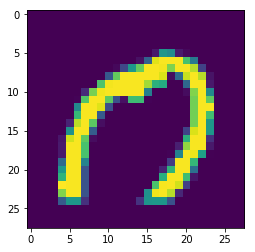

In [184]:
plt.imshow(test[17484][:,:,0])